In [1]:
from label_names import *
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image,ImageFilter

path = os.getcwd()
if path.split('/')[-1] == 'notebooks':
    os.chdir('..')
    
from src.engine import Engine
from src.core.criterions import *
from src.utils.util import *
from src.core.datasets import *
from torch.utils.data import DataLoader
from torchvision import transforms

import torchvision 
%matplotlib inline

In [2]:
#config_path = 'configs/mln_vit_imagenet.yml'
config_path = 'configs/mln_resnet18_imagenet.yml'
save_dir = '/data/private/Uncertainty-CAM/notebook_test'
imagenet_pwd = "/data/opensets/imagenet-pytorch/train"
checkpoint_path = '/data/private/Uncertainty-CAM/ckpt_imagenet_vit/checkpoint_best.pth'
#checkpoint_path = '/data/private/Uncertainty-CAM/ckpt_imagenet_noise/checkpoint_best_.pth'

logger = load_log(save_dir)

In [3]:
engine = Engine(config_path, logger, save_dir,device='cuda')
engine.model_config['checkpoint_path'] = checkpoint_path
engine.define()


[2022-02-19 13:02:47,854 - /data/private/Uncertainty-CAM/notebook_test] GPU is available.
[2022-02-19 13:02:47,859 - /data/private/Uncertainty-CAM/notebook_test] Build a dataloader
[2022-02-19 13:02:54,948 - /data/private/Uncertainty-CAM/notebook_test] Build a model
[2022-02-19 13:02:56,265 - /data/private/Uncertainty-CAM/notebook_test] Using multi-GPU
[2022-02-19 13:02:59,637 - /data/private/Uncertainty-CAM/notebook_test] Build a Optimizer, Scheduler etc...
[2022-02-19 13:02:59,639 - /data/private/Uncertainty-CAM/notebook_test] SGD opimizer is built.
[2022-02-19 13:02:59,640 - /data/private/Uncertainty-CAM/notebook_test] CUSTOM scheduler is built.
[2022-02-19 13:02:59,645 - /data/private/Uncertainty-CAM/notebook_test] Criterion is built.
[2022-02-19 13:02:59,645 - /data/private/Uncertainty-CAM/notebook_test] Loss meter is built.
[2022-02-19 13:02:59,646 - /data/private/Uncertainty-CAM/notebook_test] Checkpointer is built.
[2022-02-19 13:02:59,647 - /data/private/Uncertainty-CAM/notebo

## ImageNet Accuracy 

In [4]:
transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
imagenet_val  = torchvision.datasets.ImageNet('/data/opensets/imagenet-pytorch', split='val',
                                             transform=transform)
len(imagenet_val)

50000

In [5]:
engine._validate_once(0)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
[2022-02-19 12:09:20,944 - /data/private/Uncertainty-CAM/notebook_test] [Epoch 0] Evaluation batch 1/13
[2022-02-19 12:09:23,842 - /data/private/Uncertainty-CAM/notebook_test] [Epoch 0] Evaluation batch 2/13
[2022-02-19 12:09:26,789 - /data/private/Uncertainty-CAM/notebook_test] [Epoch 0] Evaluation batch 3/13
[2022-02-19 12:09:29,646 - /data/private/Un

0.6522800003242493

In [14]:
#sum(correct)/len(correct) 
# ResNet50      0.775
# ViT-MLN       0.773
# ResNet50-MLN  0.6522800003242493

0.0

## UAM

In [4]:
imagenet_train  = torchvision.datasets.ImageNet('/data/opensets/imagenet-pytorch', split='val')
print(len(imagenet_train))

loss_types = ['mace_avg','alea_avg','second']

50000


In [117]:
img, label = imagenet_train[8606]

def getUAM(engine,img,label, transform=True):
    list_of_cams = list()
    #plt.imshow(img)
    img = torch.tensor(np.array(img))/255.
    #img = (img-torch.tensor([0.5,0.5,0.5]))/torch.tensor([0.5,0.5,0.5])
    img = (img- torch.tensor([0.485, 0.456, 0.406]))/torch.tensor([0.229, 0.224, 0.225])
    img = img.permute(-1,0,1).unsqueeze(0)
    if transform:
        img = torchvision.transforms.Resize(256)(img)
        img = torchvision.transforms.CenterCrop(224)(img)
    origin_img = img
    origin_img = origin_img.squeeze().permute(1,2,0)
    #origin_img = origin_img*torch.tensor([0.5,0.5,0.5]) + torch.tensor([0.5,0.5,0.5])
    origin_img = origin_img*torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    #plt.imshow(img[0].permute(1,2,0)*torch.tensor([0.5,0.5,0.5]) + torch.tensor([0.5,0.5,0.5]))
    with torch.no_grad():
        out_dict = engine.model(img)
        largest_pi = torch.argmax(out_dict['pi']).detach().cpu().numpy()
        select_index = torch.argmax(out_dict['mu'][0,largest_pi]).detach().cpu().numpy()
        confidence = out_dict['mu'][0,largest_pi][select_index]

    for i,loss_type in enumerate(loss_types):
        engine.localizer.register_hooks()

        engine.localizer.model_ext.loss_type= loss_type

        cams = engine.localizer.localize(torch.tensor(img).to('cuda').float(), 
                                         torch.tensor(select_index).unsqueeze(0).to('cuda'))
        engine.localizer.remove_hooks()
        cams = cams.cpu().detach().squeeze().numpy()
        list_of_cams.append(cams)
    return list_of_cams, confidence, origin_img,select_index

list_of_cams, confidence, origin_img, select_index = getUAM(engine,img,label)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


172 172


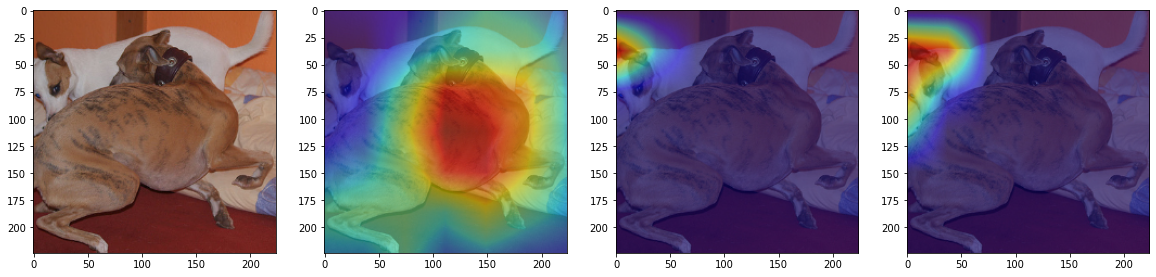

In [118]:
plt.figure(figsize=(20,10))

print(label,select_index)

plt.subplot(1,4,1)
plt.imshow(origin_img)

plt.subplot(1,4,2)
plt.imshow(origin_img)
plt.imshow(list_of_cams[0], cmap='jet', alpha=0.5)

plt.subplot(1,4,3)
plt.imshow(origin_img)
plt.imshow(list_of_cams[1], cmap='jet', alpha=0.5)

plt.subplot(1,4,4)
plt.imshow(origin_img)
plt.imshow(list_of_cams[2], cmap='jet', alpha=0.5)

## Cutout Region

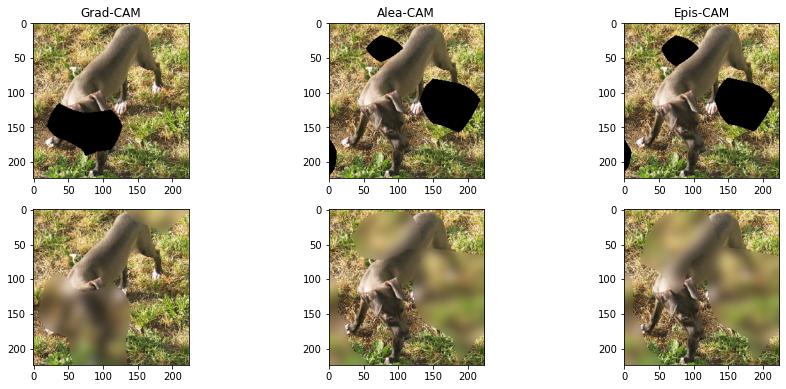

In [106]:
def getMask(list_of_cams, ratio=0.5):
    grad_cam = list_of_cams[0]
    alea_cam = list_of_cams[1]
    epis_cam = list_of_cams[2]
    alea_mask = alea_cam> ratio*np.max(alea_cam)
    epis_mask = epis_cam> ratio*np.max(epis_cam)
    grad_mask = grad_cam> ratio*np.max(grad_cam)
    alea_img = origin_img*(1-np.stack([alea_mask,alea_mask,alea_mask],axis=-1))
    epis_img = origin_img*(1-np.stack([epis_mask,epis_mask,epis_mask],axis=-1))
    grad_img = origin_img*(1-np.stack([grad_mask,grad_mask,grad_mask],axis=-1))
    return alea_mask,epis_mask,grad_mask, alea_img,epis_img,grad_img,

def getBlur(list_of_cams, origin_img, ratio=7, mask_ratio=0.2):
    blur_img = cv2.GaussianBlur(origin_img.numpy(),(0,0),7)
    alea_mask,epis_mask,grad_mask,alea_img,epis_img,grad_img = getMask(list_of_cams,mask_ratio)
    #alea_blur
    blur_part_alea = blur_img*(np.stack([alea_mask,alea_mask,alea_mask],axis=-1))
    nonblur_part_alea = origin_img*(1-np.stack([alea_mask,alea_mask,alea_mask],axis=-1))
    blur_alea = nonblur_part_alea + blur_part_alea
    #epis blur
    blur_part_epis = blur_img*(np.stack([epis_mask,epis_mask,epis_mask],axis=-1))
    nonblur_part_epis = origin_img*(1-np.stack([epis_mask,epis_mask,epis_mask],axis=-1))
    blur_epis = nonblur_part_epis + blur_part_epis
    #grad blur
    blur_part_grad = blur_img*(np.stack([grad_mask,grad_mask,grad_mask],axis=-1))
    nonblur_part_grad = origin_img*(1-np.stack([grad_mask,grad_mask,grad_mask],axis=-1))
    blur_grad = nonblur_part_grad + blur_part_grad
    return blur_alea, blur_epis, blur_grad

alea_mask,epis_mask,grad_mask,alea_img,epis_img,grad_img = getMask(list_of_cams)
blur_imgs = getBlur(list_of_cams, origin_img)

plt.figure(figsize=(15,20))
plt.subplot(6,3,1)
plt.title("Grad-CAM")
plt.imshow(grad_img)
#plt.imshow(alea_mask, alpha=0.5)

plt.subplot(6,3,2)
plt.title("Alea-CAM")
plt.imshow(alea_img)

plt.subplot(6,3,3)
plt.title("Epis-CAM")
plt.imshow(epis_img )

plt.subplot(6,3,4)
plt.imshow(blur_imgs[-1] )

plt.subplot(6,3,5)
plt.imshow(blur_imgs[0] )

plt.subplot(6,3,6)
plt.imshow(blur_imgs[1] )

## Mask Drop Ratio

In [27]:
sample_idx_list = random.sample([i for i in range(len(imagenet_train))], k = 100)

original_conf = list()
alea_mask_conf = list()
epis_mask_conf = list()
grad_mask_conf = list()

correct_origin = list()
correct_mask   = list()
correct_grad   = list()

for sample_idx in tqdm(sample_idx_list):
    img,label = imagenet_train[sample_idx]
    list_of_cams, confidence, origin_img,sel = getUAM(engine,img,label)
    correct_1 = (sel==label)
    alea_mask,epis_mask,grad_mask,alea_img,epis_img,grad_img = getMask(list_of_cams, ratio=0.5)
    alea_blur,epis_blur,grad_blur = getBlur(list_of_cams, origin_img,mask_ratio=0.2)
    
    #_, confidence2, _ = getUAM(engine, (alea_img*255).float(), 0, False)
    _, confidence2, _, sel = getUAM(engine, (alea_blur*255).float(), 0, False)
    correct_2 = (sel==label)
    
    _, confidence3, _, sel_grad = getUAM(engine, (grad_blur*255).float(), 0, False)
    correct_3 = (sel_grad==label)
    
    correct_origin.append(correct_1)
    correct_mask.append(correct_2)
    correct_grad.append(correct_3)
    
    original_conf.append(float(confidence.cpu().numpy()))
    alea_mask_conf.append(float(confidence2.cpu().numpy()))
    grad_mask_conf.append(float(confidence3.cpu().numpy()))

  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


before acc      :  0.57
alea - mask acc :  0.57
grad drop acc   :  0.11
conf mean         :  0.659284532405436
aela - mask conf  :  0.6834342145174742
grad - mask conf  :  0.3806470249965787


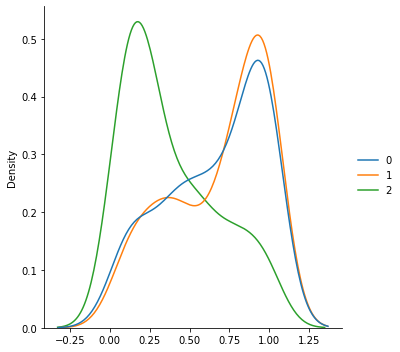

In [28]:
import seaborn as sns

print("before acc      : ",sum(correct_origin)/len(correct_origin))
print("alea - mask acc : ",sum(correct_mask)/len(correct_mask))
print("grad drop acc   : ",sum(correct_grad)/len(correct_grad))
print("="*30)
print("conf mean         : ",sum(original_conf)/len(original_conf))
print("aela - mask conf  : ",sum(alea_mask_conf)/len(alea_mask_conf))
print("grad - mask conf  : ",sum(grad_mask_conf)/len(grad_mask_conf))

sns.displot([original_conf,alea_mask_conf,grad_mask_conf], kind="kde")